In [1]:
import model
import optimizer as opt
import function as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 数値微分の実装
function.pyに以下のようなnumerical_gradient関数を定義した。

In [2]:
def numerical_gradient(f, x):
    h = 1e-3 # 0.001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

### test

In [3]:
def function(x):
    return x[0]**2+x[1]**2

In [4]:
numerical_gradient(function, np.array([3.0,4.0])) #6,8が出力される

array([6., 8.])

In [5]:
F.numerical_gradient(function, np.array([3.0,4.0])) #functionの方でも同様の結果

array([6., 8.])

### 数値微分による重み更新
optimizerと名前をつけた都合上SGDを使用していますが、基本的にはただの数値微分による更新です。

GNNクラスのattributeとして以下の関数を実装

|attribute|内容|
|---|---|
|get_label|sigmoid関数を適用した後1/2を閾値としてラベルづけする|
|loss|binary_cross_entropyの損失関数の結果を示す|
|numerical_gradient|学習器θを数値微分し、$W,A,b$それぞれの微分値の辞書を返す|

In [6]:
#optimizer.pyにSGD, MomentumSGD, Adamのクラスを作成した。初期値としてハイパーパラメーターを持ち、updateによって値を更新する
class SGD:
    def __init__(self, lr=1e-4):
        self.lr=lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key]=params[key]-self.lr*grads[key]

In [7]:
D=8
gnn=model.GNN(D)
optimizer=opt.SGD()

### 隣接行列を取得しておく。
今回はtrain_dataの0_graph.txtを取り出した。

In [8]:
cdir=os.getcwd()

In [9]:
arr=[]
graph0=os.path.join(cdir,"datasets","train")+"/0_graph.txt"
with open(graph0) as graph:
    lines=graph.readlines()
    for line in lines[1:]:
        line=line.rstrip("\n")
        arr.append(list(map(int, line.split())))
        
adj=np.array(arr)

In [10]:
adj

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]])

### lossが減少することを確認する。
labelは1とした

In [11]:
import tqdm
T=2
iter_nums=10000
loss_list=[]
y=0
for i in tqdm.tqdm(range(iter_nums)):
    grads=gnn.numerical_gradient(adj, y)
    params=gnn.theta
    optimizer.update(params, grads)  
    loss_list.append(gnn.loss(adj,y))
    

100%|██████████| 10000/10000 [05:25<00:00, 30.70it/s]


Text(0.5, 0, 'iter_nums')

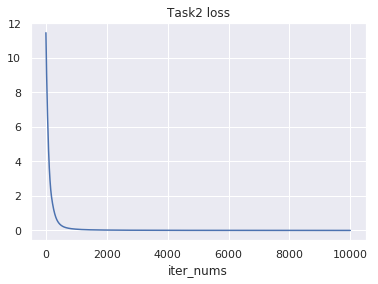

In [12]:
sns.set()
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(np.arange(len(loss_list)),loss_list)
ax.set_title("Task2 loss")
ax.set_xlabel("iter_nums")

In [13]:
loss_list[-1]

array([0.00238412])

lossが減少しており、この学習では十分な数の繰り返しで0.002程度まで低下していることがわかる